In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Geometry and Grid Setup
L = 20
d = 20
Nx = 100
Ny = 100
x = np.linspace(0, L, Nx)
y = np.linspace(0, d, Ny)
X, Y = np.meshgrid(x, y)

# Boundary Conditions
T_top = 100.0
T_bottom = 25.0
T_left = 25.0
T_right = 25.0

In [24]:
class PINN(nn.Module):
    def __init__(self, input_dim=2, hidden_layers=4, units=32):
        super(PINN, self).__init__()
        layers = [nn.Linear(input_dim, units), nn.Tanh()]
        for _ in range(hidden_layers - 1):
            layers += [nn.Linear(units, units), nn.Tanh()]
        layers += [nn.Linear(units, 1)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [25]:
def get_boundary_data(N=500, device='cpu'):
    def edge(x_vals, y_vals, t_vals):
        return np.column_stack((x_vals, y_vals)), t_vals

    x_top = np.random.uniform(0, L, N)
    y_top = d * np.ones_like(x_top)
    T_top_vec = T_top * np.ones_like(x_top)

    x_bot = np.random.uniform(0, L, N)
    y_bot = np.zeros_like(x_bot)
    T_bot_vec = T_bottom * np.ones_like(x_bot)

    y_left = np.random.uniform(0, d, N)
    x_left = np.zeros_like(y_left)
    T_left_vec = T_left * np.ones_like(y_left)

    y_right = np.random.uniform(0, d, N)
    x_right = L * np.ones_like(y_right)
    T_right_vec = T_right * np.ones_like(y_right)

    X_b = np.vstack([
        np.column_stack((x_top, y_top)),
        np.column_stack((x_bot, y_bot)),
        np.column_stack((x_left, y_left)),
        np.column_stack((x_right, y_right))
    ])
    T_b = np.concatenate([T_top_vec, T_bot_vec, T_left_vec, T_right_vec])

    X_b = torch.tensor(X_b, dtype=torch.float32).to(device)
    T_b = torch.tensor(T_b.reshape(-1, 1), dtype=torch.float32).to(device)
    return X_b, T_b

In [26]:
def get_collocation_points(N=2000, device='cpu'):
    x_c = np.random.uniform(0, L, N)
    y_c = np.random.uniform(0, d, N)
    X_c = np.column_stack((x_c, y_c))
    return torch.tensor(X_c, dtype=torch.float32).to(device)

In [27]:
def pinn_loss(model, X_bc, T_bc, X_colloc, q_gen=0.0, k=1.0):
    mse = nn.MSELoss()
    T_pred_bc = model(X_bc)
    mse_data = mse(T_pred_bc, T_bc)

    X_colloc.requires_grad_(True)
    T_pred = model(X_colloc)

    grads = torch.autograd.grad(T_pred, X_colloc, grad_outputs=torch.ones_like(T_pred),
                                create_graph=True, retain_graph=True)[0]
    dT_dx = grads[:, 0:1]
    dT_dy = grads[:, 1:2]

    d2T_dx2 = torch.autograd.grad(dT_dx, X_colloc, grad_outputs=torch.ones_like(dT_dx),
                                  create_graph=True, retain_graph=True)[0][:, 0:1]
    d2T_dy2 = torch.autograd.grad(dT_dy, X_colloc, grad_outputs=torch.ones_like(dT_dy),
                                  create_graph=True, retain_graph=True)[0][:, 1:2]

    physics = d2T_dx2 + d2T_dy2 + q_gen / k
    mse_physics = torch.mean(physics**2)

    return 0.5 * mse_data + 0.5 * mse_physics

# ===== Train Function =====
def train(model, X_bc, T_bc, X_colloc, epochs=2000, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_history = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = pinn_loss(model, X_bc, T_bc, X_colloc)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
        loss_history.append(loss.item())
    return loss_history

# ===== Visualization =====
def visualize(model, device='cpu'):
    x = np.linspace(0, L, Nx)
    y = np.linspace(0, d, Ny)
    X, Y = np.meshgrid(x, y)
    XY = np.column_stack((X.ravel(), Y.ravel()))
    XY_tensor = torch.tensor(XY, dtype=torch.float32).to(device)

    with torch.no_grad():
        T_pred = model(XY_tensor).cpu().numpy().reshape(Ny, Nx)

    plt.figure(figsize=(8, 6))
    contour = plt.contourf(X, Y, T_pred, 100, cmap='hot')
    plt.colorbar(contour, label="Temperature (°C)")
    plt.title("Predicted Temperature Distribution")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PINN().to(device)
X_bc, T_bc = get_boundary_data(device=device)
X_colloc = get_collocation_points(device=device)
train(model, X_bc, T_bc, X_colloc, epochs=2000, lr=0.001)


Epoch 0, Loss: 1496.180542
Epoch 100, Loss: 1214.671509
Epoch 200, Loss: 1084.498169
Epoch 300, Loss: 981.576111
Epoch 400, Loss: 895.874817
Epoch 500, Loss: 823.963501
Epoch 600, Loss: 763.768555
Epoch 700, Loss: 713.709961
Epoch 800, Loss: 672.453857
Epoch 900, Loss: 638.818237
Epoch 1000, Loss: 611.733154
Epoch 1100, Loss: 590.223450
Epoch 1200, Loss: 573.401245
Epoch 1300, Loss: 560.464600
Epoch 1400, Loss: 550.696228
Epoch 1500, Loss: 543.464722
Epoch 1600, Loss: 538.223755
Epoch 1700, Loss: 534.507080
Epoch 1800, Loss: 530.877258
Epoch 1900, Loss: 454.601471


[1496.1805419921875,
 1493.61376953125,
 1491.0589599609375,
 1488.4886474609375,
 1485.8804931640625,
 1483.2137451171875,
 1480.47119140625,
 1477.638916015625,
 1474.7071533203125,
 1471.669677734375,
 1468.5223388671875,
 1465.263671875,
 1461.8914794921875,
 1458.40673828125,
 1454.8089599609375,
 1451.0999755859375,
 1447.2816162109375,
 1443.3570556640625,
 1439.33154296875,
 1435.212158203125,
 1431.0072021484375,
 1426.727294921875,
 1422.3839111328125,
 1417.989501953125,
 1413.556884765625,
 1409.0987548828125,
 1404.628173828125,
 1400.1575927734375,
 1395.6983642578125,
 1391.261474609375,
 1386.8565673828125,
 1382.4931640625,
 1378.178955078125,
 1373.921630859375,
 1369.7271728515625,
 1365.600830078125,
 1361.5469970703125,
 1357.570068359375,
 1353.671875,
 1349.8551025390625,
 1346.1212158203125,
 1342.470947265625,
 1338.9053955078125,
 1335.424560546875,
 1332.0277099609375,
 1328.7147216796875,
 1325.4842529296875,
 1322.3349609375,
 1319.2647705078125,
 1316.2717

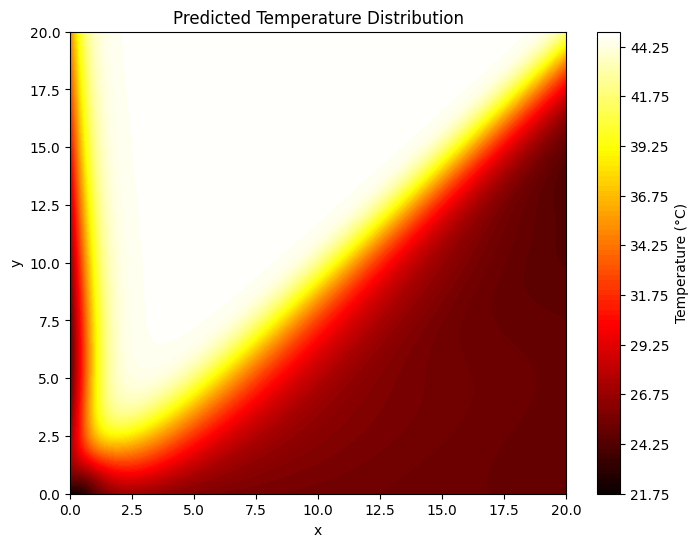

In [29]:
visualize(model, device=device)

In [31]:
def plot_temperature_surface(model, device='cpu'):
    x = np.linspace(0, L, Nx)
    y = np.linspace(0, d, Ny)
    X, Y = np.meshgrid(x, y)
    XY = np.column_stack((X.ravel(), Y.ravel()))
    XY_tensor = torch.tensor(XY, dtype=torch.float32).to(device)

    with torch.no_grad():
        T_pred = model(XY_tensor).cpu().numpy().reshape(Ny, Nx)

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    surf = ax.plot_surface(X, Y, T_pred, cmap='jet', linewidth=0.5, antialiased=True, edgecolor='k')

    # Color bar
    cbar = fig.colorbar(surf, shrink=0.5, aspect=10)
    cbar.set_label('Temperature (°C)', fontsize=12)

    # Axis labels
    ax.set_xlabel('width (m)', fontsize=12)
    ax.set_ylabel('height (m)', fontsize=12)
    ax.set_zlabel('Temperature (°C)', fontsize=12)
    ax.set_title('Distribution with heat generation', fontsize=14)

    # Adjust viewing angle if needed
    ax.view_init(elev=30, azim=135)  # You can adjust azim/elev to rotate

    plt.tight_layout()
    plt.show()


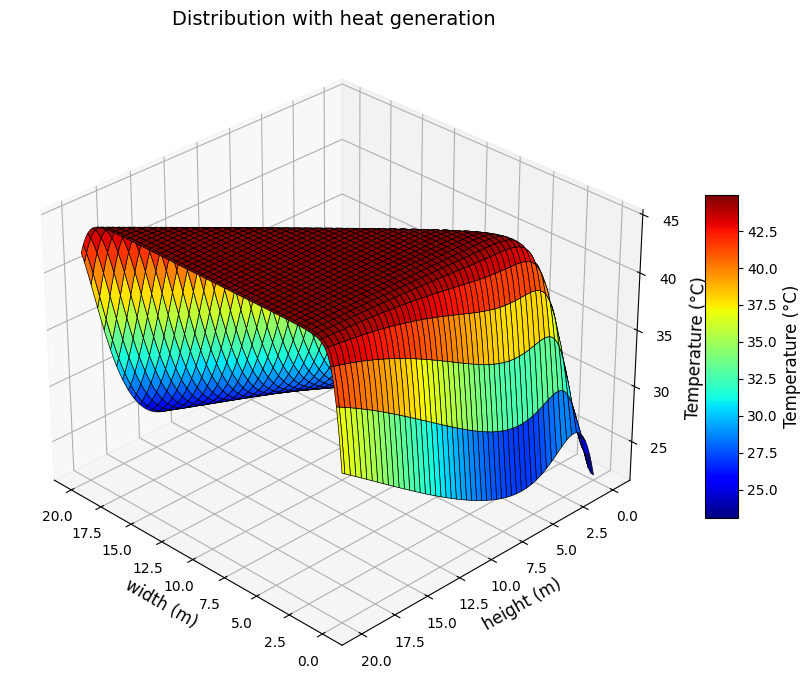

In [32]:
plot_temperature_surface(model)